# rl5E_lite_par.ipynb

Used to run parallel simulations of the model in `rl5E_lite`, returning the mean reward and the weight matrices for each.

In [1]:
%cd /home/z/projects/draculab/
# Move to the draculab home folder

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter
from multiprocessing import Pool
import pickle

In [3]:
%cd /home/z/projects/draculab/notebook/spinal/rl
# Move to the folder with the rl5E_lite_from_cfg file is
from rl5E_lite_from_cfg import rl5E_net

/home/z/projects/draculab/notebook/spinal/rl


In [4]:
# The parameters and their ranges
# Default values set to equal rl5E_lite.ipynb on 1/21/21
ranges = {"C_sigma": {"low": 0.01, "high": 1., "default": 0.4 }, # yes
          "C_slope": {"low": 1., "high": 3., "default": 2. },
          "C_thresh": {"low": 0.0, "high": .2, "default":0.2},
          "C_integ_amp": {"low": 0.0, "high": 1.5, "default": 0.0},
          "C_custom_inp_del": {"low": 10, "high": 300, "default": 150}, # seemingly replaced in the code
          "M_des_out_w_abs_sum": {"low": 0.5, "high": 3., "default":1.6},
          "P_mu": {"low": .1, "high": 2., "default":1.},
          "P_inp_gain": {"low": 0.5, "high": 4., "default":2.},
          "SF_slope": {'low':0.5, "high":3., "default":2.},
          "V_slope": {"low": 0.3, "high": 2.5, "default":1.5}, #yes
          "V_delta": {"low": .2, "high": 4., "default":1.}, #yes
          "V_thresh": {"low": -0.1, "high": 2., "default":0.}, 
          "V_td_lrate": {"low": 0.2, "high": 7., "default": 1.}, # yes
          "V_td_gamma": {"low": 0.1, "high": .9, "default": .6}, # yes
          "V_w_sum": {"low": 10., "high": 100., "default": 60.}, # yes
          "X_slope": {"low": 2., "high": 10., "default":5.}, #yes
          "X_thresh": {"low": -0.2, "high": 1., "default":0.}, # no
          "X_del": {"low": 0., "high": 1.5, "default":0.35},
          "X_lrate": {"low": 50., "high": 400., "default":200.},
          "X_w_sum": {"low": 10., "high": 80., "default": 30.}, # yes
          "A__M_lrate": {"low": 0.05, "high": 10., "default":5.},
          "A__M_w_sum": {"low": 0.3, "high": 2., "default":.4},
          "A__M_w_max": {"low": 0.2, "high": .4, "default":.3},
          "M__C_lrate": {"low": 1., "high": 400., "default":100.}
         }

# Create a default configuration
cfg = {}
for name in ranges:
    cfg[name] = ranges[name]['default']
    
cfg['sim_time1'] = 4000.  # simulation time with switching X
cfg['sim_time2'] = 500.  # simulation time with free X
cfg['pres_interv'] = 5.  # time per target presentation 
    
#cfg

In [5]:
def eval_config(cfg):
    """ Returns mean reward and weights for a given configuration. 
    
        Two simulations are run, one with switching X for cfg['sim_time1'] seconds,
        and one without switching X for cfg['sim_time2'] seconds.
        
        Args:
            cfg : parameter dictionary to initialze rl5E_net. 
            
        Returns:
            A dictionary with 4 entries:
                'mean_R1' : mean reward in the first (X switch) simulation.
                'mean_R2' : mean reward in the second (X free) simulation.
                'Vw' : L__V weight vector.
                'Xw' : L__X weight vector.
    """
    net, pops_dict = rl5E_net(cfg, 
                          pres_interv=cfg['pres_interv'],
                          rand_w=False,
                          par_heter=0.1,
                          x_switch=True,
                          V_normalize=True,
                          X_normalize=True)
    
    R = pops_dict['R']
    V = pops_dict['V']
    X = pops_dict['X']
    
    times1, data1, plant_data1 = net.run(cfg['sim_time1'])
    R_data1 = data1[R[0]]
    mean_R1 = np.mean(R_data1)
    
    net.units[pops_dict['X'][0]].switch = False # stop swtiching
    net.units[V[0]].alpha = 0.1 * net.min_delay # decrease L__V learning rate
    net.units[X[0]].alpha = 0.05                # decrease L__X learning rate
    
    times2, data2, plant_data2 = net.run(cfg['sim_time2'])
    R_data2 = data2[R[0]]
    mean_R2 = np.mean(R_data2)
    
    Vw = net.units[V[0]].buffer[1:,-1]
    Xw = net.units[X[0]].buffer[1:,-1]
    
    results = {'mean_R1' : mean_R1,
               'mean_R2' : mean_R2,
               'Vw' : Vw,
               'Xw' : Xw }
    
    return results

In [6]:
# Create the list of configurations (X_type=x_net)

# one configuration from rl5E_lite_hyper
gene_cfg = {'V_slope': 1.5,
            'V_delta': 2.5,
            'V_td_lrate': 0.3350351863301838, 
            'V_td_gamma': 0.1, 
            'V_w_sum': 60.0, 
            'X_slope': 5.0, 
            'X_del': 0.3, 
            'X_lrate': 300.0, 
            'X_w_sum': 55.0, 
            'fitness': 0.2601113238633763, 
            'n_evals': 1, 
            'C_sigma': 0.4, 
            'C_slope': 2.0, 
            'C_thresh': 0.2, 
            'C_integ_amp': 0.0, 
            'C_custom_inp_del': 150, 
            'M_des_out_w_abs_sum': 1.6, 
            'P_mu': 1.0, 
            'P_inp_gain': 2.0, 
            'V_thresh': 0.0, 
            'X_thresh': 0.0, 
            'A__M_lrate': 5.0, 
            'A__M_w_sum': 0.4, 
            'A__M_w_max': 0.3, 
            "SF_slope": 2.,
            'M__C_lrate': 100.0}

gene_cfg2 = {'V_slope': 2.0,
         'V_delta': 1.9351772436025465,
         'V_td_lrate': 4.25,
         'V_td_gamma': 0.95,
         'V_w_sum': 35.0,
         'X_slope': 3.5,
         'X_del': 0.9,
         'X_lrate': 200.0,
         'X_w_sum': 62.666806463642374,
         'fitness': 0.2863618487384629,
         'n_evals': 2,
         'C_sigma': 0.4,
         'C_slope': 2.0,
         'C_thresh': 0.2,
         'C_integ_amp': 0.0,
         'C_custom_inp_del': 150,
         'M_des_out_w_abs_sum': 1.6,
         'P_mu': 1.0,
         'P_inp_gain': 2.0,
         'V_thresh': 0.0,
         'X_thresh': 0.0,
         'A__M_lrate': 5.0,
         'A__M_w_sum': 0.4,
         'A__M_w_max': 0.3,
         'M__C_lrate': 100.0,
         'SF_slope': 2.0}

gene_cfg3 = {'V_slope': 0.9, 
             'V_delta': 0.6, 
             'V_td_lrate': 1.5, 
             'V_td_gamma': 0.6, 
             'V_w_sum': 40.60398356202898, 
             'X_slope': 5.0, 
             'X_del': 0.9, 
             'X_w_sum': 55.0, 
             'fitness': 0.24819411511566303, 
             'n_evals': 1, 
             'C_sigma': 0.4, 
             'C_slope': 2.0, 
             'C_thresh': 0.2, 
             'C_integ_amp': 0.0, 
             'C_custom_inp_del': 150, 
             'M_des_out_w_abs_sum': 1.6, 
             'P_mu': 1.0, 
             'P_inp_gain': 2.0, 
             'V_thresh': 0.0, 
             'X_thresh': 0.0, 
             'A__M_lrate': 5.0, 
             'A__M_w_sum': 0.4, 
             'A__M_w_max': 0.3, 
             'M__C_lrate': 100.0, 
             'SF_slope': 2.0, 
             'X_lrate': 200.0}


configs = [cfg.copy() for _ in range(7)]

# ----- configs[0] ----- first generation winner
n=0
configs[n] = gene_cfg.copy()
# ----- configs[1] ----- second generation winner
n=1
configs[n] = gene_cfg2.copy()
# ----- configs[2] ----- defaults, -copy1, gene1 hybrid
n=2
configs[n]['P_inp_gain'] = 3.
configs[n]['SF_slope'] = 2.
configs[n]['V_slope'] = 1.5
configs[n]['V_delta'] = 2.
configs[n]['V_w_sum'] = 50.
configs[n]['X_w_sum'] = 50.
configs[n]['pres_interv'] = 5.
configs[n]['V_td_lrate'] = .5
configs[n]['X_lrate'] = 250.
configs[n]['td_gamma'] = 0.8
configs[n]['X_del'] = 0.3
# ----- configs[3] ----- gene_cfg with higher X delay
n=3
configs[n] = gene_cfg.copy()
configs[n]['X_del'] = 0.5
# ----- configs[4] ----- gene1 hybrid with higher X delay
n=4
configs[n]['P_inp_gain'] = 3.
configs[n]['SF_slope'] = 2.
configs[n]['V_slope'] = 2.
configs[n]['V_delta'] = 2.
configs[n]['V_w_sum'] = 50.
configs[n]['X_w_sum'] = 50.
configs[n]['pres_interv'] = 5.
configs[n]['V_td_lrate'] = .5
configs[n]['X_lrate'] = 250.
configs[n]['td_gamma'] = 0.8
configs[n]['X_del'] = 0.6
# ----- configs[5] ----- defaults, gene2, -Copy1 hybrid
n=5
configs[n] = gene_cfg2.copy()
configs[n]['P_inp_gain'] = 3.
configs[n]['SF_slope'] = 2.
configs[n]['V_slope'] = 1.5
configs[n]['V_w_sum'] = 50.
configs[n]['X_w_sum'] = 60.
configs[n]['V_td_lrate'] = 2.
configs[n]['X_lrate'] = 150.
configs[n]['td_gamma'] = 0.9

# ----- configs[6] ----- third generation winner
n=6
configs[n] = gene_cfg3.copy()


n_reps = 5
n_configs = len(configs)

for cf in configs:
    cf['sim_time1'] = 4000.  # simulation time with switching X
    cf['sim_time2'] = 500.  # simulation time with free X
    cf['pres_interv'] = 5.  # time per target presentation 

configs = n_reps*configs

In [7]:
# configurations for x_netB
cfg = configs[0]
# cfg['X_type'] = unit_types.x_netB
# cfg['r_thr'] = np.pi/6.
# cfg['X_lrate'] = 20.
cfg['X_thresh'] = 1.3 # roughly mean input when X_w_sum=40

configs = [cfg.copy() for _ in range(16)]
# ------ configs[0] ------- Default parameters
# ------ configs[1] ------- 
n = 1
configs[n]['X_tau_slow'] = 300.
# ------ configs[2] ------- 
n = 2
configs[n]['X_refr_per'] = 1.
# ------ configs[3] ------- 
n = 3
configs[n]['X_tau_slow'] = 300.
configs[n]['X_refr_per'] = 1.
# ------ configs[4] ------- 
n = 4
configs[n]['V_delta'] = 2.
# ------ configs[5] ------- 
n = 5
configs[n]['V_delta'] = 2.
configs[n]['X_tau_slow'] = 300.
# ------ configs[6] ------- 
n = 6
configs[n]['V_delta'] = 2.
configs[n]['X_refr_per'] = 1.
# ------ configs[7] ------- 
n = 7
configs[n]['V_delta'] = 2.
configs[n]['X_tau_slow'] = 300.
configs[n]['X_refr_per'] = 1.
# ------ configs[8:15] ------
for idx, cfg in enumerate(configs[:8]):
    configs[8+idx] = cfg.copy()
    configs[8+idx]['pres_interv'] = 4.

n_reps = 2
n_configs = len(configs)

for cf in configs:
    cf['sim_time1'] = 2000.  # simulation time with switching X
    cf['sim_time2'] = 500.  # simulation time with free X
    #cf['pres_interv'] = 5.  # time per target presentation 

configs = n_reps*configs

In [8]:
# Parallel runs of 'eval_config'
n_procs = 16
print('Starting %d processes' % (n_procs))
start_time = time.time()
#all_results = list(map(eval_config, configs)) giga
with Pool(n_procs) as p:
    all_results = list(p.map(eval_config, configs))
    #all_results = p.map(eval_config, configs)
    p.close()
    p.join()
print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 

Starting 16 processes
****** Processing finished after 8463.717344999313 seconds ******


In [9]:
# save the results
from datetime import datetime
import pickle
fname = "rl5E_lite_par"
fname += "_" + datetime.now().strftime('%Y-%m-%d__%H_%M')
with open(fname, 'wb') as f:
    pickle.dump({'configs':configs, 'all_results':all_results}, f)
    f.close()

#all_results

In [8]:
for i, result in enumerate(all_results):
    print("index:%d, R1: %f, R2: %f, diff=%f " % (i, result['mean_R1'], result['mean_R2'], result['mean_R2']-result['mean_R1']))

index:0, R1: 0.646105, R2: 0.778693, diff=0.132589 
index:1, R1: 0.617606, R2: 0.755224, diff=0.137619 
index:2, R1: 0.631159, R2: 0.751959, diff=0.120800 
index:3, R1: 0.566581, R2: 0.720342, diff=0.153761 
index:4, R1: 0.617751, R2: 0.781421, diff=0.163670 
index:5, R1: 0.627082, R2: 0.734828, diff=0.107746 
index:6, R1: 0.620941, R2: 0.746391, diff=0.125449 
index:7, R1: 0.573079, R2: 0.698449, diff=0.125369 
index:8, R1: 0.607678, R2: 0.764029, diff=0.156351 
index:9, R1: 0.614628, R2: 0.769874, diff=0.155246 
index:10, R1: 0.631214, R2: 0.771546, diff=0.140331 
index:11, R1: 0.599063, R2: 0.742972, diff=0.143909 
index:12, R1: 0.584762, R2: 0.741448, diff=0.156686 
index:13, R1: 0.635280, R2: 0.772437, diff=0.137156 
index:14, R1: 0.634550, R2: 0.734355, diff=0.099806 
index:15, R1: 0.539394, R2: 0.716559, diff=0.177165 
index:16, R1: 0.619139, R2: 0.756541, diff=0.137402 
index:17, R1: 0.626580, R2: 0.755002, diff=0.128422 
index:18, R1: 0.596942, R2: 0.760745, diff=0.163803 
ind

In [38]:
configs[0]

{'V_slope': 1.5,
 'V_delta': 2.5,
 'V_td_lrate': 0.3350351863301838,
 'V_td_gamma': 0.1,
 'V_w_sum': 60.0,
 'X_slope': 5.0,
 'X_del': 0.3,
 'X_lrate': 300.0,
 'X_w_sum': 55.0,
 'fitness': 0.2601113238633763,
 'n_evals': 1,
 'C_sigma': 0.4,
 'C_slope': 2.0,
 'C_thresh': 0.2,
 'C_integ_amp': 0.0,
 'C_custom_inp_del': 150,
 'M_des_out_w_abs_sum': 1.6,
 'P_mu': 1.0,
 'P_inp_gain': 2.0,
 'V_thresh': 0.0,
 'X_thresh': 1.3,
 'A__M_lrate': 5.0,
 'A__M_w_sum': 0.4,
 'A__M_w_max': 0.3,
 'SF_slope': 2.0,
 'M__C_lrate': 100.0,
 'sim_time1': 2000.0,
 'sim_time2': 500.0,
 'pres_interv': 4.0,
 'X_switch': True,
 'V_normalize': True,
 'X_normalize': True,
 'X_type': <unit_types.x_net: 127>,
 'r_thr': 0.5235987755982988,
 'X_tau_slow': 50.0,
 'X_refr_per': 2.0}

In [35]:
# compare two configurations
n_cfg1 = 0
n_cfg2 = 8
for name in configs[n_cfg1]:
    if name in configs[n_cfg2] and configs[n_cfg2][name] != configs[n_cfg1][name]:
        print('cfg1: ' + name + '=' + str(configs[n_cfg1][name]), end='; ')
        print('cfg2: ' + name + '=' + str(configs[n_cfg2][name]))

In [10]:
# Load the results from a previous run of rl5E_lite_par
# You need to adjust according to the number of repetitions
%cd /home/z/projects/draculab/saves
#%cd /home/sergio/projects/draculab/notebook/spinal/rl
fname = 'rl5E_lite_par_2021-01-27__15_17'
with (open(fname, "rb")) as f:
    res_dict = pickle.load(f)
    f.close()
    
configs = res_dict['configs']
all_results = res_dict['all_results']
n_reps = 20 # this needs to be adjusted accordingly !!!!!!
n_configs = int(np.round(len(configs)/n_reps))

/home/z/projects/draculab/saves


To produce the graphs used in figure 6 of the paper:
* Load 'rl5E_lite_par_2021-01-27__15_17' in the cell above, using n_reps=20
* Run the next 3 cells below 
    * In the next cell ("plot rewards before/after learning for a given configuration") use cfg_num=0
    * In the second cell ("display connection matrices") use n_rep=6

-0.03794598844772418


Ttest_relResult(statistic=3.4590848892247785, pvalue=0.17915837670493784)

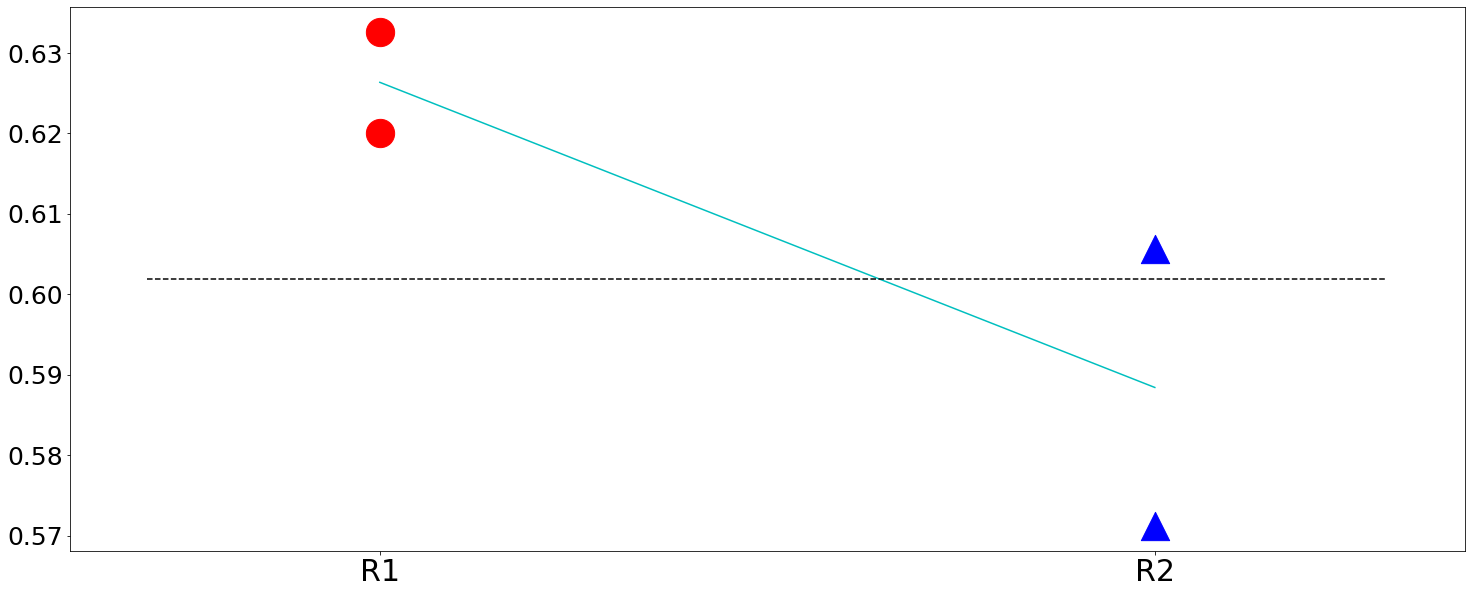

In [11]:
# plot rewards before/after learning for a given configuration
cfg_num = 0
idxs = list(range(cfg_num, len(configs), n_configs))

res_fig0 = plt.figure(figsize=(25,10))
mR1 = np.array([all_results[i]['mean_R1'] for i in idxs])
mR2 = np.array([all_results[i]['mean_R2'] for i in idxs])
plt.scatter(np.ones_like(idxs), mR1, marker='o', s=800, c='r')
plt.scatter(2.*np.ones_like(idxs), mR2, marker='^', s=800, c='b')
plt.plot([1., 2.], [np.mean(mR1), np.mean(mR2)], c='c')
mid = (max(mR1) + min(mR2)) / 2.
plt.plot([.7, 2.3], [mid, mid], 'k--')
plt.xticks([1, 2], ['R1', 'R2'], fontsize=30)
ax = plt.gca()
ax.yaxis.set_tick_params(labelsize=25)
plt.xlim(0.6,2.4)

# print average difference value and t-test
r_diffs = np.array([all_results[i]['mean_R2'] - all_results[i]['mean_R1'] for i in idxs])
print(np.mean(r_diffs))
from scipy import stats
#stats.ttest_ind(mR1, mR2)
stats.ttest_rel(mR1, mR2)

Text(0.5, 1.0, 'L--X weights')

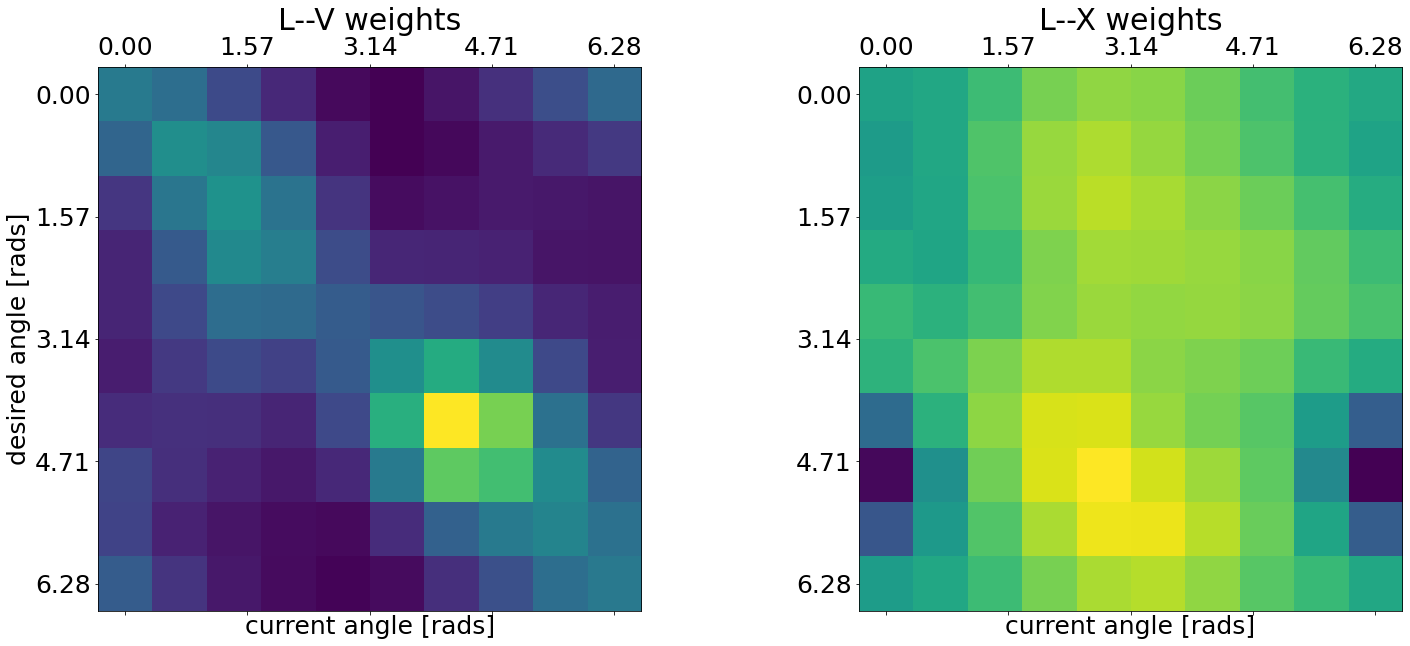

In [13]:
# display connection matrices
n_rep = 1 # for which repetition of the configuration (chosen in the previous cell)
mat_fig0 , mat_axs0 = plt.subplots(1, 2, figsize=(25, 10))
xs0 = mat_axs0[0]
xs1 = mat_axs0[1]
xs0.matshow(all_results[idxs[n_rep]]['Vw'].reshape(10,10))
xs1.matshow(all_results[idxs[n_rep]]['Xw'].reshape(10,10))

xs0.set_ylabel('desired angle [rads]', fontsize=25)
xs0.set_xlabel('current angle [rads]', fontsize=25)
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
xs0.set_xticks(ticks)
xs0.set_xticklabels(labels)
xs0.xaxis.set_tick_params(labelsize=25)
xs0.set_yticks(ticks)
xs0.set_yticklabels(labels)
xs0.yaxis.set_tick_params(labelsize=25)
xs0.set_title('L--V weights', fontsize=30)

#xs1.set_ylabel('desired angle [rads]', fontsize=25)
xs1.set_xlabel('current angle [rads]', fontsize=25)
xs1.set_xticks(ticks)
xs1.set_xticklabels(labels)
xs1.xaxis.set_tick_params(labelsize=25)
xs1.set_yticks(ticks)
xs1.set_yticklabels(labels)
xs1.yaxis.set_tick_params(labelsize=25)
xs1.set_title('L--X weights', fontsize=30)

Text(0.5, 1.0, 'X output')

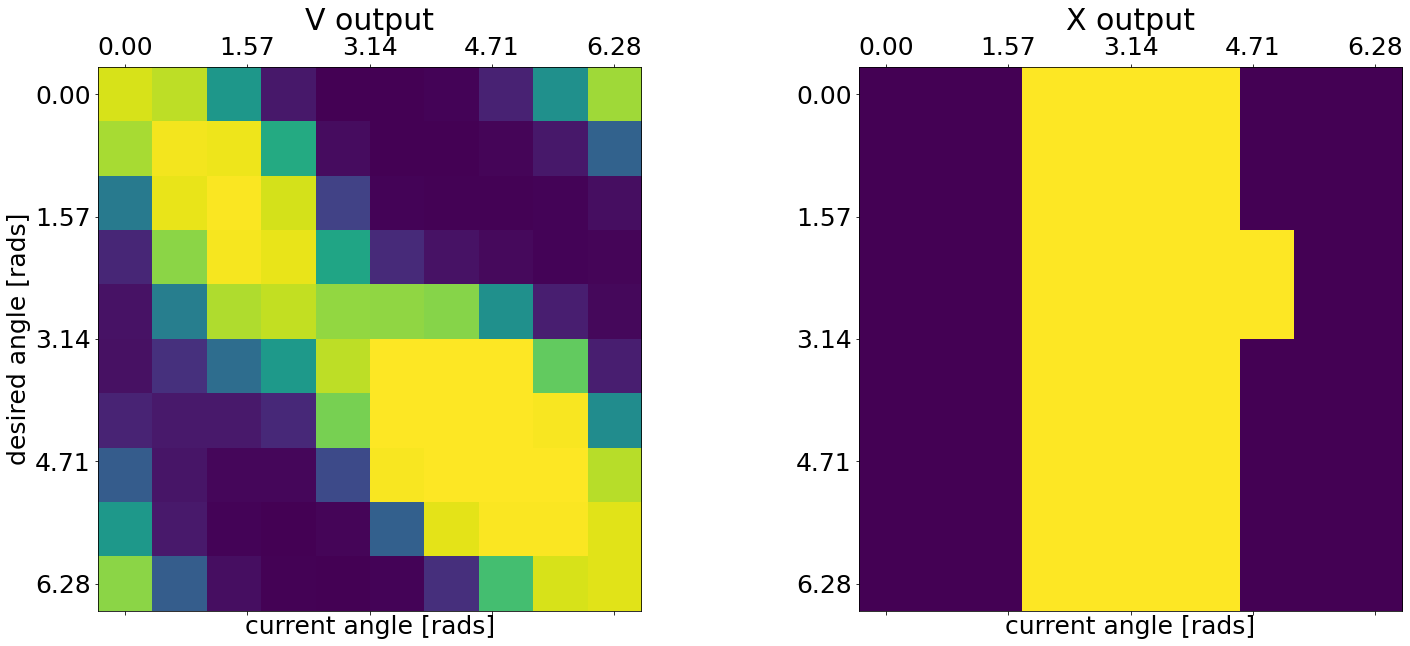

In [14]:
# Display outputs of V and X for the L centers

# For the purpose of plotting, we instantiate a network
net, pops_dict = rl5E_net(configs[idxs[n_rep]], 
                          pres_interv=cfg['pres_interv'],
                          rand_w=False,
                          par_heter=0.1,
                          x_switch=True,
                          V_normalize=True,
                          X_normalize=True)
X = pops_dict['X']
V = pops_dict['V']
x = net.units[X[0]]
v = net.units[V[0]]
x_weights = all_results[idxs[n_rep]]['Xw']
v_weights = all_results[idxs[n_rep]]['Vw']
x_outs = np.zeros(len(x.centers))
v_outs = np.zeros(len(v.centers))
I_x = np.zeros_like(x_outs)
I_v = np.zeros_like(v_outs)

for idx, angles in enumerate(x.centers):
    d = x.dists(angles)
    l_acts = np.exp(-x.L_wid * d * d)
    I_x[idx] = (l_acts*x_weights).sum()

for idx, angles in enumerate(v.centers):
    d = v.dists(angles)
    l_acts = np.exp(-v.L_wid * d * d)
    I_v[idx] = (l_acts*v_weights).sum()
    
I_x_m = np.mean(I_x)
I_v_m = np.mean(I_v)
x_outs = np.sign(np.array([x.f(i - I_x_m) for i in I_x])-0.5)
v_outs = np.array([v.f(i - I_x_m) for i in I_v])

mat_fig1 , mat_axs1 = plt.subplots(1, 2, figsize=(25, 10))
xs0 = mat_axs1[0]
xs1 = mat_axs1[1]
xs0.matshow(v_outs.reshape(10,10))
xs1.matshow(x_outs.reshape(10,10))

xs0.set_ylabel('desired angle [rads]', fontsize=25)
xs0.set_xlabel('current angle [rads]', fontsize=25)
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
xs0.set_xticks(ticks)
xs0.set_xticklabels(labels)
xs0.xaxis.set_tick_params(labelsize=25)
xs0.set_yticks(ticks)
xs0.set_yticklabels(labels)
xs0.yaxis.set_tick_params(labelsize=25)
xs0.set_title('V output', fontsize=30)

#xs1.set_ylabel('desired angle [rads]', fontsize=25)
xs1.set_xlabel('current angle [rads]', fontsize=25)
xs1.set_xticks(ticks)
xs1.set_xticklabels(labels)
xs1.xaxis.set_tick_params(labelsize=25)
xs1.set_yticks(ticks)
xs1.set_yticklabels(labels)
xs1.yaxis.set_tick_params(labelsize=25)
xs1.set_title('X output', fontsize=30)

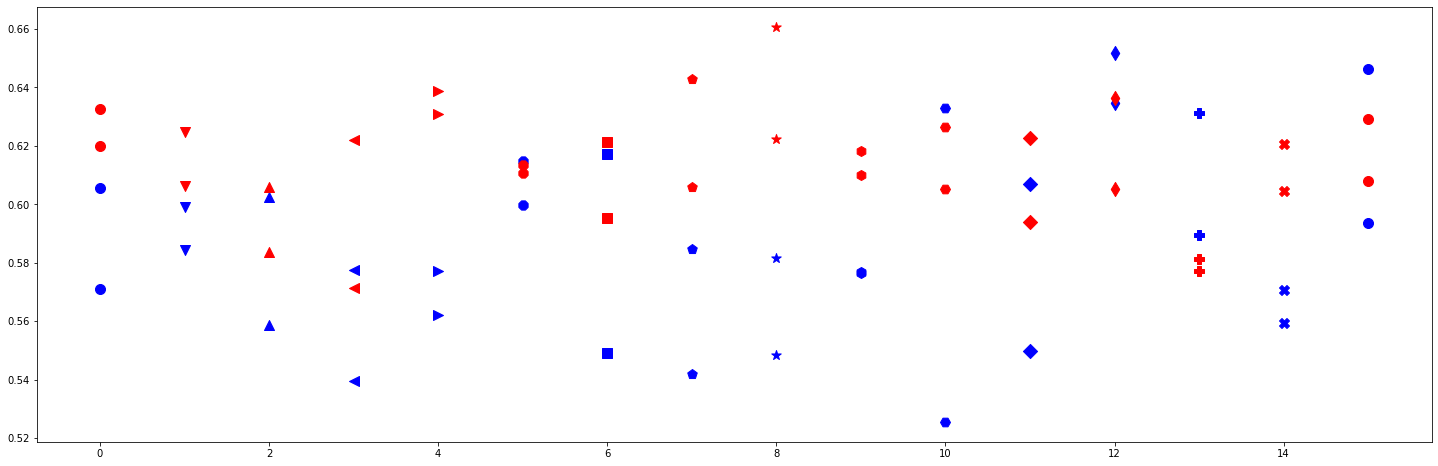

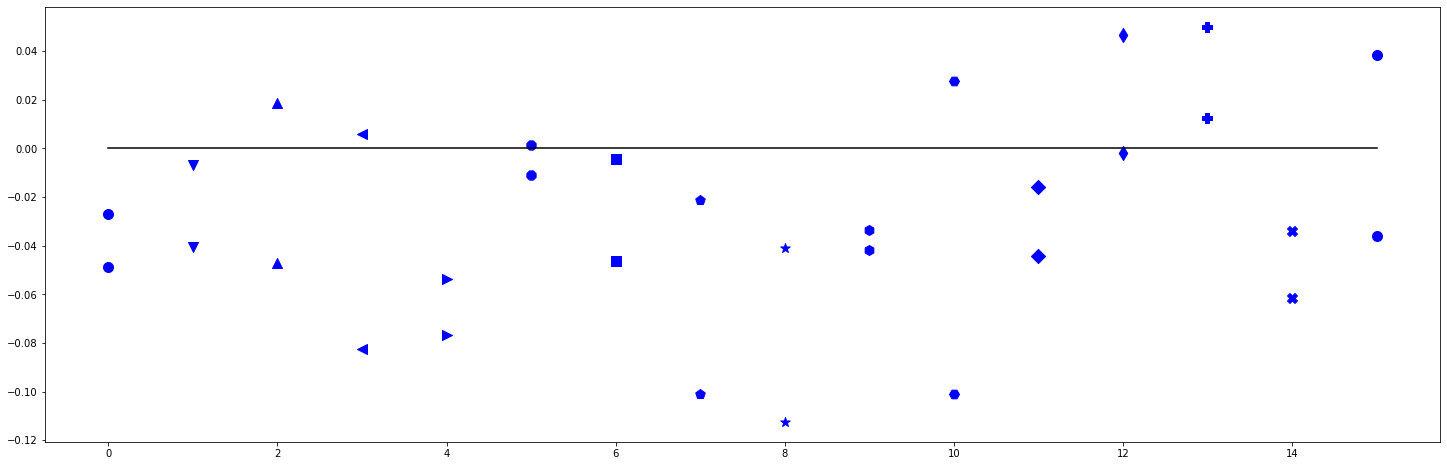

Number of times R2 > R1:


array([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 2., 0., 1.])

In [36]:
res_fig1 = plt.figure(figsize=(25,8))
markers = ['o' ,'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o']
mstyle1 = dict(s=100, c='b')
mstyle2 = dict(s=100, c='r')
for r in range(n_reps):
    for c in range(n_configs):
        plt.scatter([c],[all_results[r*n_configs+c]['mean_R2']],marker=markers[c], **mstyle1)
        plt.scatter([c],[all_results[r*n_configs+c]['mean_R1']],marker=markers[c], **mstyle2)
        
res_fig2 = plt.figure(figsize=(25,8))
for r in range(n_reps):
    for c in range(n_configs):
        plt.scatter([c],[all_results[r*n_configs+c]['mean_R2']-all_results[r*n_configs+c]['mean_R1']],marker=markers[c], **mstyle1)
plt.plot(range(n_configs), np.zeros(n_configs), 'k-')
        
plt.show()

wins = np.zeros(n_configs)
for r in range(n_reps):
    for c in range(n_configs):
        if all_results[r*n_configs+c]['mean_R2'] > all_results[r*n_configs+c]['mean_R1']:
            wins[c] += 1

print("Number of times R2 > R1:")
wins

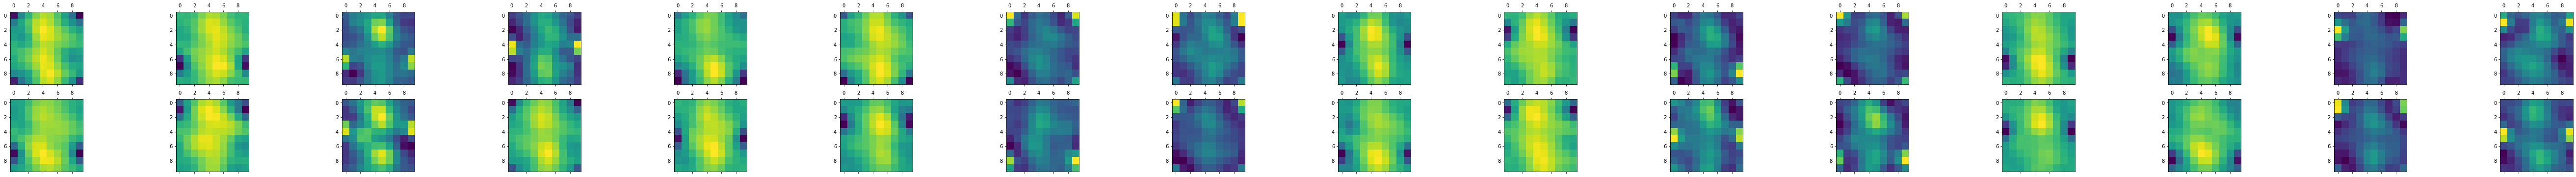

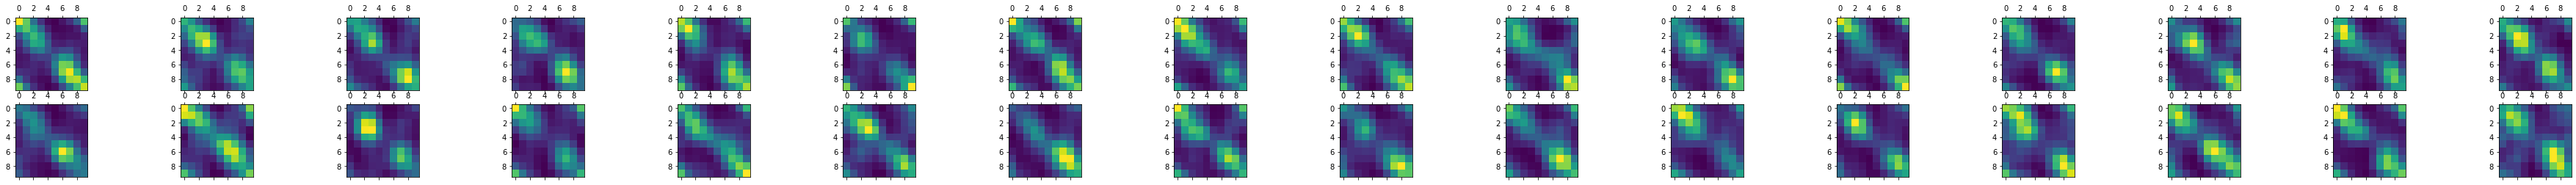

In [16]:
n_reps = 2
n_confs = 16
all_Xw_fig , all_Xw_axs = plt.subplots(n_reps,n_confs, figsize=(6*n_configs,3*n_reps))
for conf in range(n_confs):
    for rep in range(n_reps):
        ax = all_Xw_axs[rep, conf]
        ax.matshow(all_results[rep*n_confs+conf]['Xw'].reshape(10,10))
        
all_Vw_fig , all_Vw_axs = plt.subplots(n_reps,n_confs, figsize=(4*n_configs,2*n_reps))
for conf in range(n_confs):
    for rep in range(n_reps):
        ax = all_Vw_axs[rep, conf]
        ax.matshow(all_results[rep*n_confs+conf]['Vw'].reshape(10,10))
plt.show()

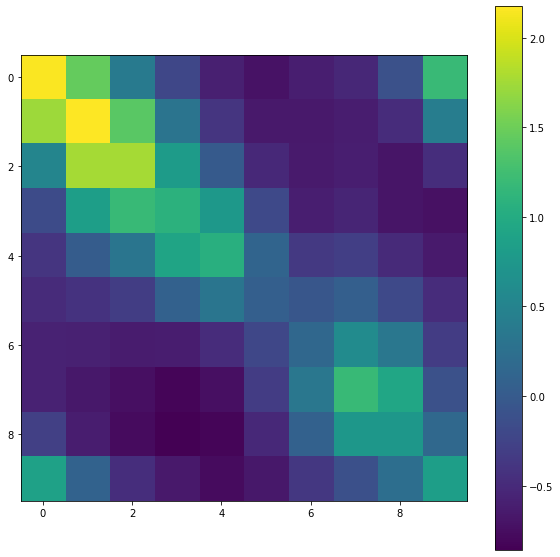

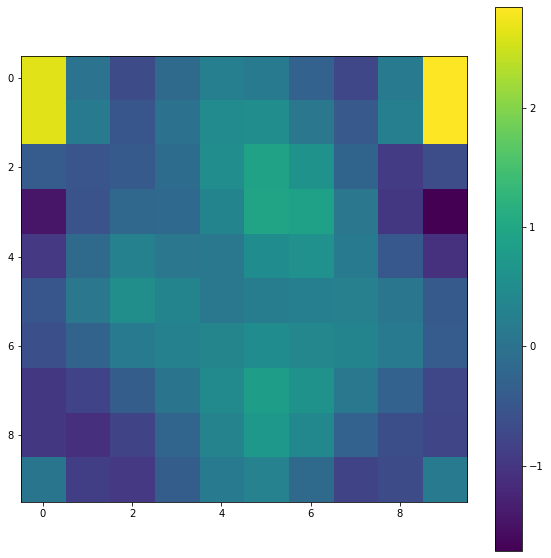

In [23]:
n = 7
Xw = all_results[n]['Xw']
Vw = all_results[n]['Vw']

V_fig = plt.figure(figsize=(10,10))
V_ax = plt.subplot(1,1,1)
Vcs = V_ax.imshow(Vw.reshape(10,10))
V_fig.colorbar(Vcs)

X_fig = plt.figure(figsize=(10,10))
X_ax = plt.subplot(1,1,1)
Xcs = X_ax.imshow(Xw.reshape(10,10))
X_fig.colorbar(Xcs)

plt.show()

In [ ]:
# Setting a static value for X
net.units[X[0]].switch = False # stop switching
net.units[X[0]].thresh = 0.

In [ ]:
# Setting, fixing controller weights
# standard values:
# A__M_mat = np.rray([[0.27141863, 0.29511766, 0.23279135, 0.20067437],
#                     [0.23307357, 0.1957229 , 0.28739239, 0.28380952]])

# M__C_mat = np.array([[0.0295056,  2.05108517],
#                      [2.05111951, 0.02950648]])
# limit values:
A__M_mat = np.array([[0.4, .5, 0.08, 0.018],
                    [0.05, 0. , 0.4, 0.5]])

M__C_mat = np.array([[0.,  2.15],
                     [2.15, 0.]])


for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                syn.alpha = 1e-4 # slowing down learning
                break

for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                syn.alpha = 1e-4 # slowing down learning
                break
                

In [ ]:
sim_time = 4.
#ratio = 15.1 # cns-amd
ratio = 1.4 # breaker
#ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

In [ ]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

In [ ]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=1*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [ ]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [ ]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# MPLEX
MPLEX_fig = plt.figure(figsize=fs) #(30,12))
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

# V, R
V_fig = plt.figure(figsize=(30,10)) #fs)
V_data = np.array(data[V])
R_data = np.array(data[R])
#R = np.exp(-net.units[V[0]].R_wid * np.abs(MPLEX_data[0,:]-MPLEX_data[1,:]))
plt.plot(times, V_data.transpose())
plt.plot(times, R_data.transpose())
plt.title('V, R')
#plt.plot(times, R, linewidth=4)
plt.legend(['V', 'R'])

# # M--C0 weights
# W_fig1 = plt.figure(figsize=fs)
# w_track_data = np.array(data[M_C0_track])
# plt.plot(times, w_track_data.transpose())
# plt.legend(['M0-C0', 'M1-C0'])
# plt.title('M--C0 weights')

# # A--M0 weights
# W_fig2 = plt.figure(figsize=fs)
# w_track_data2 = np.array(data[A_M0_track])
# plt.plot(times, w_track_data2.transpose())
# plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
# plt.title('A--M0 weights')

plt.show()

In [ ]:
# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, 0.5*np.ones(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))

# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

In [ ]:
# P, DA
pres_interv=5.
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.plot(times, des_angs[(times/pres_interv).astype(int)], label='des_ang')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])


In [ ]:
max(net.units[V[0]].buffer[1:,-1]) - min(net.units[V[0]].buffer[1:,-1])

In [ ]:
net.units[V[0]].buffer[1:,-1]

In [ ]:
net.units[V[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.imshow(net.units[V[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
plt.show()

In [ ]:
max(net.units[X[0]].buffer[1:,-1]) - min(net.units[X[0]].buffer[1:,-1])

In [ ]:
net.units[V[0]].buffer[1:,-1].sum()

In [ ]:
# Visualize L__V weights
n_plots = 20 # number of plots, each at a different time
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots/n_rows))
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

L__V_fig, L__V_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_cols*fs[1]))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = L__V_axs[row][col]
    cs = ax.imshow(data[v_track][:,t_idxs[i_plot]].reshape(No2,No2))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

In [ ]:
# Visualize L__X weights
n_plots = 20 # number of plots, each at a different time
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots/n_rows))
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

L__X_fig, L__X_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_cols*fs[1]))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = L__X_axs[row][col]
    cs = ax.imshow(data[x_track][:,t_idxs[i_plot]].reshape(No2,No2))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

In [ ]:
L_out_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(net.units[V[0]].L_out_copy.reshape(10,10))
L_out_fig.colorbar(cs)
plt.show()

In [ ]:
net.units[V[0]].L_out_copy.sum()

In [ ]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

In [ ]:
plotty = plotter(net, times, data)

In [ ]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [ ]:
plotty.conn_anim(L, V)

In [ ]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [ ]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

In [ ]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================
net, pops_dict = rl5E_net(cfg, 
                          pres_interv=5.,
                          rand_w=False,
                          par_heter=0.1,
                          x_switch=True,
                          V_normalize=True,
                          X_normalize=True)

for name in pops_dict:
    exec(name + '=' + str(pops_dict[name]))
des_angs = np.array(des_angs)

In [ ]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [ ]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in V:
        pre_pop = 'V'
    elif pre_id in MPLEX:
        pre_pop = 'MPLEX'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in MPLEX:
        pre_pop = 'MPLEX'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


---